# Palm Oil Disease Classification - YOLOv8 Training

This notebook trains a **YOLOv8 Classification** model (`-cls`) for palm oil leaf disease detection.

**Task**: Image Classification (Categorizing the whole image)
**Dataset Structure**: `datasets/palm-tree-leaves-diseases/{split}/{class_name}`

## 1. Setup and Installation

In [1]:
# Install required packages if not already present
!pip install ultralytics roboflow opencv-python pillow matplotlib

In [2]:
import os
import shutil
from pathlib import Path
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import yaml

# Check Device
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Quadro RTX 5000


## 2. Define Dataset Path
Since we are doing classification with an existing folder structure, we point directly to the dataset root.

In [3]:
# Define path relative to this notebook (notebooks/ -> datasets/)
dataset_path = Path("../datasets/palm-tree-leaves-diseases").resolve()

train_dir = dataset_path / "train"
val_dir = dataset_path / "valid"
test_dir = dataset_path / "test"

print(f"Dataset Root: {dataset_path}")
print(f"Train Directory Exists: {train_dir.exists()}")

Dataset Root: /data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases
Train Directory Exists: True


## 3. Explore Dataset (Classification Mode)
We infer class names from the folder names.

In [4]:
# Get class names from folder names in 'train'
if train_dir.exists():
    classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
    print(f"Detected Classes ({len(classes)}): {classes}")
    
    # Count images
    train_count = len(list(train_dir.rglob('*.jpg')))
    val_count = len(list(val_dir.rglob('*.jpg')))
    print(f"Training images: {train_count}")
    print(f"Validation images: {val_count}")
else:
    print("❌ Error: Train directory not found at path!")

Detected Classes (9): ['Black Scorch', 'Fusarium Wilt', 'Healthy sample', 'Leaf Spots', 'Magnesium Deficiency', 'Manganese Deficiency', 'Parlatoria Blanchardi', 'Potassium Deficiency', 'Rachis Blight']
Training images: 2020
Validation images: 578


Sample images per class:


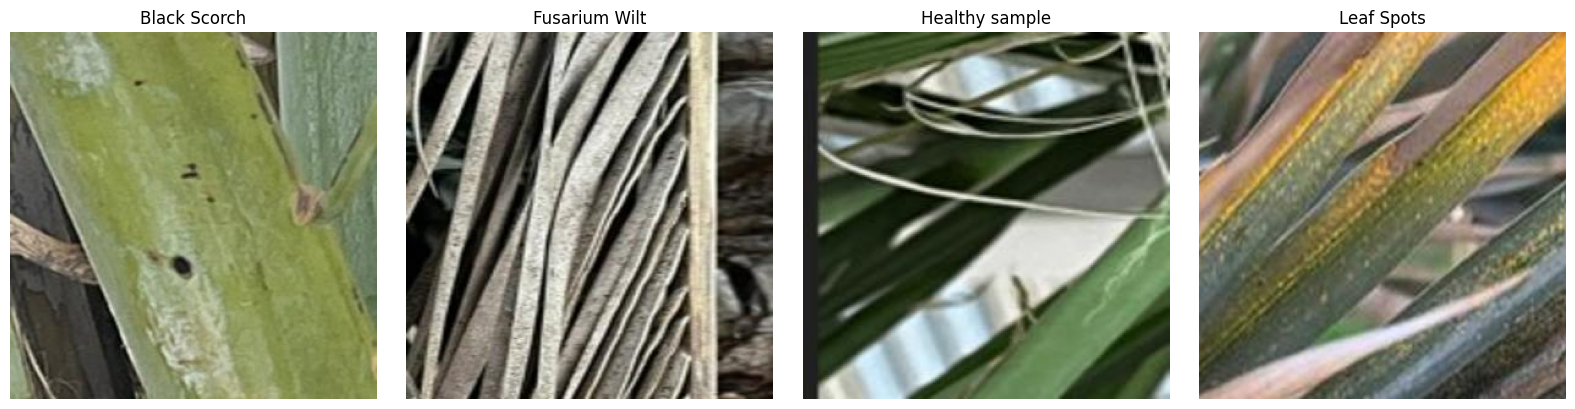

In [5]:
# Visualize sample images from different classes
def visualize_samples(root_dir, class_list, num_samples=4):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 4))
    
    # Select first few classes to display
    display_classes = class_list[:num_samples]
    
    for idx, class_name in enumerate(display_classes):
        class_path = root_dir / class_name
        images = list(class_path.glob('*.jpg'))
        
        if images:
            img = Image.open(images[0])
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(class_name)
            
    plt.tight_layout()
    plt.show()

if train_dir.exists():
    print("Sample images per class:")
    visualize_samples(train_dir, classes)

## 4. Initialize YOLO Classification Model
We use **`yolov8m-cls.pt`**. The `-cls` suffix is crucial.

In [6]:
MODEL_DIR = "../models"
MODEL_NAME = "yolov8m-cls.pt"
MODEL_PATH = f"{MODEL_DIR}/{MODEL_NAME}"
print(MODEL_PATH)

../models/yolov8m-cls.pt


In [7]:
model = YOLO(MODEL_PATH)

print(f"Model loaded from: {MODEL_PATH}")
print(f"Task: {model.task}")

Model loaded from: ../models/yolov8m-cls.pt
Task: classify


## 5. Train Model

In [8]:
# Project settings
PROJECT_NAME = "palm_disease_classification"
EXPERIMENT_NAME = "yolov8m_cls_run"
EPOCHS = 50  # Adjust as needed
BATCH_SIZE = 16
IMAGE_SIZE = 224  # Standard for classification (can use 640 if high res needed)

# Start Training
results = model.train(
    data=str(dataset_path),  # Point to root folder containing train/val
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    project=PROJECT_NAME,
    name=EXPERIMENT_NAME,
    patience=10,
    save=True,
    
    # Augmentations (tuned for classification)
    degrees=10.0,
    translate=0.1,
    scale=0.5,
    fliplr=0.5,
    mosaic=0.0,  # Mosaic is typically for detection, often disabled for cls
    
    # Optimizer
    optimizer='AdamW',
    lr0=0.001,
)

print("Training completed!")

New https://pypi.org/project/ultralytics/8.3.249 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.185 🚀 Python-3.11.13 torch-2.8.0+cu126 CUDA:0 (Quadro RTX 5000, 15928MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../models/yolov8m-cls.pt, momentum=0.937, mosaic=0.0, multi_scale

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 26.0±9.7 MB/s, size: 11.0 KB)


train: Scanning /data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases/train... 2020 images, 0 corrupt: 100%|██████████| 2020/2020 [00:01<00:00, 1682.33it/s]

train: New cache created: /data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 181.0±67.0 MB/s, size: 10.1 KB)


val: Scanning /data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases/valid... 578 images, 0 corrupt: 100%|██████████| 578/578 [00:00<00:00, 3338.81it/s]

val: New cache created: /data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases/valid.cache


optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)


2026/01/08 16:40:49 INFO mlflow.tracking.fluent: Experiment with name 'palm_disease_classification' does not exist. Creating a new experiment.


MLflow: logging run_id(045ef19edba445658e67a197b97bc2c1) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to palm_disease_classification/yolov8m_cls_run
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 11.46it/s]

                   all      0.666      0.978



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 15.50it/s]

                   all      0.853      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 16.69it/s]

                   all      0.825      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 16.37it/s]

                   all      0.794      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 16.89it/s]

                   all      0.865      0.993



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.10it/s]

                   all      0.903      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.78it/s]

                   all      0.896      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.12it/s]

                   all      0.917      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.78it/s]

                   all       0.87          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50      1.05G     0.3196          4        224: 100%|██████████| 127/127 [00:07<00:00, 16.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.89it/s]

                   all      0.865      0.997



      Epoch    GPU_mem       loss  Instances       Size


      11/50      1.05G     0.2803          4        224: 100%|██████████| 127/127 [00:07<00:00, 16.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.79it/s]

                   all      0.903      0.997



      Epoch    GPU_mem       loss  Instances       Size


      12/50      1.05G     0.2433          4        224: 100%|██████████| 127/127 [00:07<00:00, 16.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.73it/s]

                   all      0.919          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      1.05G      0.242          4        224: 100%|██████████| 127/127 [00:07<00:00, 15.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.00it/s]

                   all      0.931      0.998



      Epoch    GPU_mem       loss  Instances       Size


      14/50      1.05G      0.204          4        224: 100%|██████████| 127/127 [00:07<00:00, 16.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.67it/s]

                   all      0.934      0.997



      Epoch    GPU_mem       loss  Instances       Size


      15/50      1.05G     0.2072          4        224: 100%|██████████| 127/127 [00:08<00:00, 15.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.41it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      1.07G     0.1965          4        224: 100%|██████████| 127/127 [00:07<00:00, 16.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.05it/s]

                   all      0.912          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      1.11G      0.175          4        224: 100%|██████████| 127/127 [00:07<00:00, 16.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.36it/s]

                   all       0.92      0.998



      Epoch    GPU_mem       loss  Instances       Size


      18/50      1.11G     0.1492          4        224: 100%|██████████| 127/127 [00:08<00:00, 15.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.06it/s]

                   all      0.938      0.998



      Epoch    GPU_mem       loss  Instances       Size


      19/50      1.13G     0.1269          4        224: 100%|██████████| 127/127 [00:08<00:00, 15.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.10it/s]

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50       1.2G     0.1196          4        224: 100%|██████████| 127/127 [00:07<00:00, 15.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.89it/s]

                   all      0.927      0.998



      Epoch    GPU_mem       loss  Instances       Size


      21/50       1.2G     0.1286          4        224: 100%|██████████| 127/127 [00:08<00:00, 15.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 16.98it/s]

                   all      0.922      0.998



      Epoch    GPU_mem       loss  Instances       Size


      22/50       1.2G     0.1047          4        224: 100%|██████████| 127/127 [00:08<00:00, 15.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.89it/s]

                   all      0.939      0.997



      Epoch    GPU_mem       loss  Instances       Size


      23/50       1.2G     0.1128          4        224: 100%|██████████| 127/127 [00:07<00:00, 16.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.18it/s]

                   all      0.948      0.998



      Epoch    GPU_mem       loss  Instances       Size


      24/50       1.2G    0.09918          4        224: 100%|██████████| 127/127 [00:08<00:00, 15.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.17it/s]

                   all      0.965      0.998



      Epoch    GPU_mem       loss  Instances       Size


      25/50       1.2G    0.08085          4        224: 100%|██████████| 127/127 [00:07<00:00, 16.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 19.01it/s]

                   all      0.955      0.997



      Epoch    GPU_mem       loss  Instances       Size


      26/50      1.22G    0.07819          4        224: 100%|██████████| 127/127 [00:08<00:00, 15.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.45it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50      1.31G    0.09012          4        224: 100%|██████████| 127/127 [00:07<00:00, 16.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.90it/s]

                   all      0.964      0.998



      Epoch    GPU_mem       loss  Instances       Size


      28/50      1.31G    0.07181          4        224: 100%|██████████| 127/127 [00:08<00:00, 14.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.71it/s]

                   all      0.964          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50      1.33G    0.06669          4        224: 100%|██████████| 127/127 [00:08<00:00, 15.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.20it/s]

                   all      0.965      0.997



      Epoch    GPU_mem       loss  Instances       Size


      30/50      1.38G    0.07587          4        224: 100%|██████████| 127/127 [00:07<00:00, 15.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.11it/s]

                   all       0.96      0.997



      Epoch    GPU_mem       loss  Instances       Size


      31/50      1.38G    0.05662          4        224: 100%|██████████| 127/127 [00:07<00:00, 16.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.53it/s]

                   all      0.948      0.998



      Epoch    GPU_mem       loss  Instances       Size


      32/50       1.4G    0.06666          4        224: 100%|██████████| 127/127 [00:08<00:00, 15.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.88it/s]


                   all      0.957      0.998

      Epoch    GPU_mem       loss  Instances       Size


      33/50      1.47G    0.06001          4        224: 100%|██████████| 127/127 [00:07<00:00, 16.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.27it/s]

                   all      0.967      0.997



      Epoch    GPU_mem       loss  Instances       Size


      34/50      1.47G    0.05688          4        224: 100%|██████████| 127/127 [00:09<00:00, 14.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.36it/s]

                   all      0.965      0.998
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 24, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



34 epochs completed in 0.103 hours.
Optimizer stripped from palm_disease_classification/yolov8m_cls_run/weights/last.pt, 31.7MB
Optimizer stripped from palm_disease_classification/yolov8m_cls_run/weights/best.pt, 31.7MB

Validating palm_disease_classification/yolov8m_cls_run/weights/best.pt...
Ultralytics 8.3.185 🚀 Python-3.11.13 torch-2.8.0+cu126 CUDA:0 (Quadro RTX 5000, 15928MiB)
YOLOv8m-cls summary (fused): 42 layers, 15,774,185 parameters, 0 gradients, 41.6 GFLOPs
train: /data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases/train... found 2020 images in 9 classes ✅ 
val: /data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases/valid... found 578 images in 9 classes ✅ 
test: /data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases/test... found 292 images in 9 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 13.61it/s]


                   all      0.965      0.998
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to palm_disease_classification/yolov8m_cls_run
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Training completed!


## 6. Evaluate Model

In [9]:
# Validate
metrics = model.val()

print("\nValidation Metrics:")
print(f"Top-1 Accuracy: {metrics.top1:.4f}")
print(f"Top-5 Accuracy: {metrics.top5:.4f}")

Ultralytics 8.3.185 🚀 Python-3.11.13 torch-2.8.0+cu126 CUDA:0 (Quadro RTX 5000, 15928MiB)
YOLOv8m-cls summary (fused): 42 layers, 15,774,185 parameters, 0 gradients, 41.6 GFLOPs
train: /data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases/train... found 2020 images in 9 classes ✅ 
val: /data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases/valid... found 578 images in 9 classes ✅ 
test: /data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases/test... found 292 images in 9 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 357.7±127.3 MB/s, size: 10.1 KB)


val: Scanning /data/bayu/palm-disease-ai-service/datasets/palm-tree-leaves-diseases/valid... 578 images, 0 corrupt: 100%|██████████| 578/578 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 37/37 [00:02<00:00, 14.74it/s]


                   all      0.965      0.998
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to palm_disease_classification/yolov8m_cls_run2

Validation Metrics:
Top-1 Accuracy: 0.9654
Top-5 Accuracy: 0.9983


Training Results:


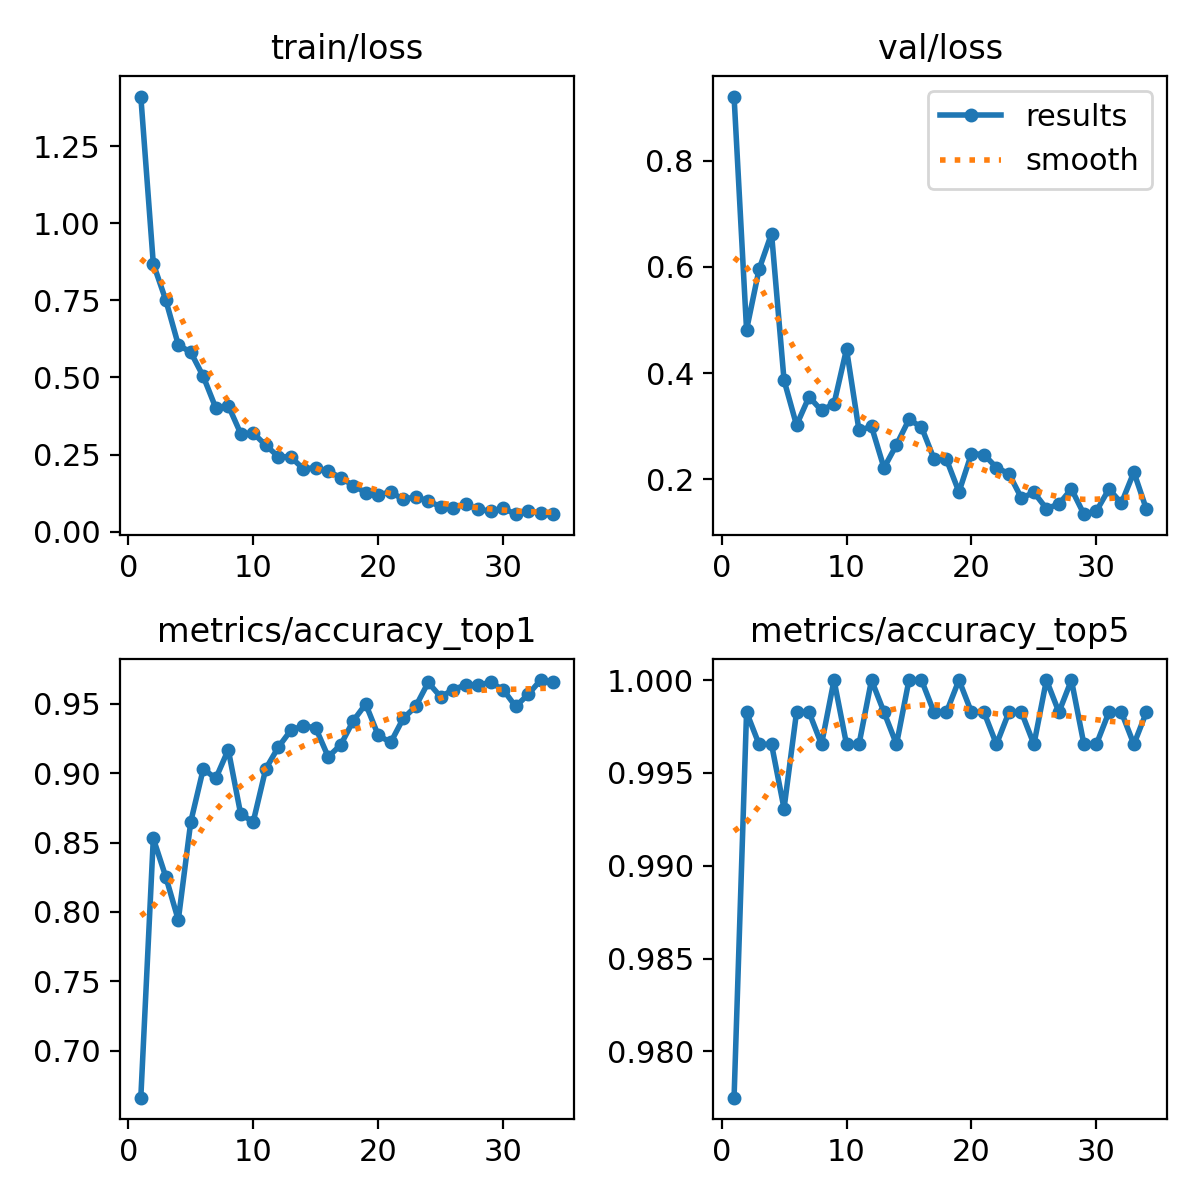


Confusion Matrix:


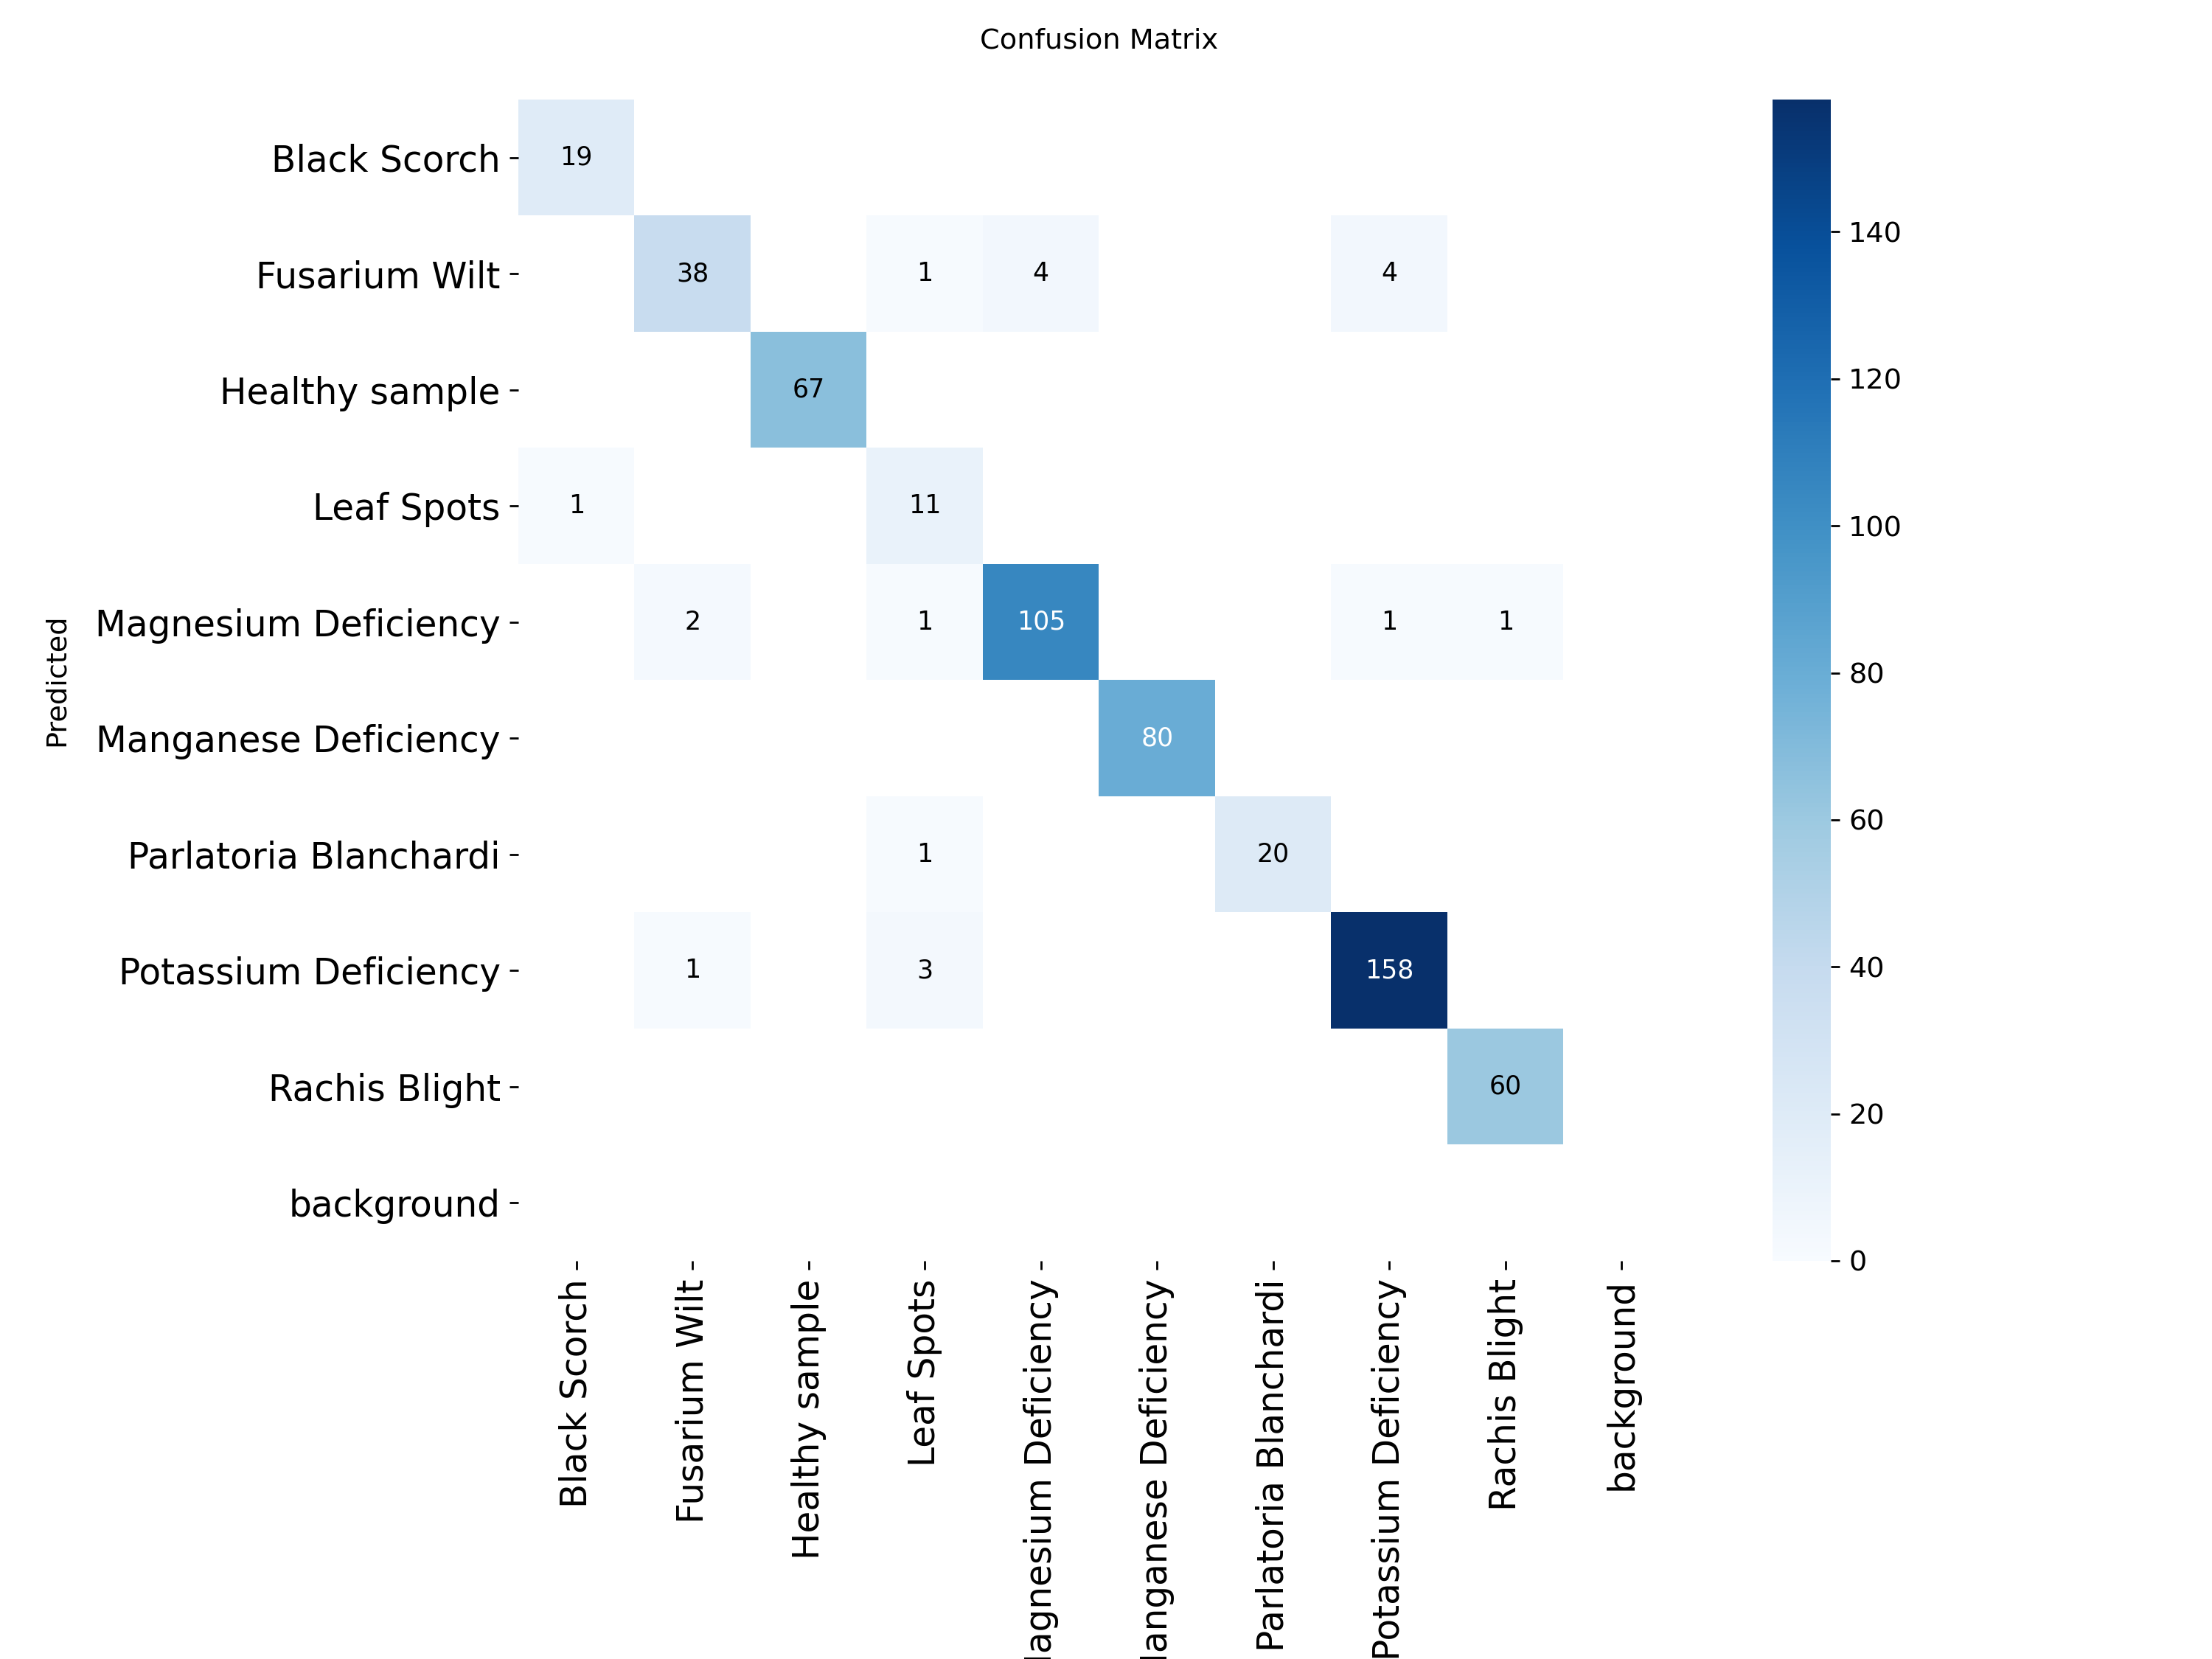

In [10]:
# Show Training Curves & Confusion Matrix
from IPython.display import Image as IPImage, display

results_dir = Path(PROJECT_NAME) / EXPERIMENT_NAME

print("Training Results:")
if (results_dir / "results.png").exists():
    display(IPImage(filename=str(results_dir / "results.png")))

print("\nConfusion Matrix:")
if (results_dir / "confusion_matrix.png").exists():
    display(IPImage(filename=str(results_dir / "confusion_matrix.png")))

## 7. Test Predictions

In [11]:
# Load the best model weights
best_model_path = results_dir / "weights" / "best.pt"
best_model = YOLO(best_model_path)

# Pick random validation images
test_images = list(val_dir.rglob('*.jpg'))[:4]

for img_path in test_images:
    # Predict
    results = best_model.predict(source=str(img_path), verbose=False)
    result = results[0]
    
    # Extract top 1 class
    top1_idx = result.probs.top1
    top1_conf = result.probs.top1conf.item()
    pred_class = result.names[top1_idx]
    
    print(f"\nImage: {img_path.name}")
    print(f"  True Class: {img_path.parent.name}")
    print(f"  Predicted:  {pred_class} ({top1_conf:.2%})")


Image: M2_-10-_png.rf.af2bfc481c559da6fc836d06c18e87e9.jpg
  True Class: Black Scorch
  Predicted:  Black Scorch (99.90%)

Image: M2_-101-_png.rf.74ce4eda6d4ecadaf2efca8d669a6470.jpg
  True Class: Black Scorch
  Predicted:  Black Scorch (98.82%)

Image: M2_-105-_png.rf.14d35240c8cfa7ca976d78b79acf14bc.jpg
  True Class: Black Scorch
  Predicted:  Leaf Spots (97.44%)

Image: M2_-14-_png.rf.22c1f4048a2e94ff8adc9d71d6ae131c.jpg
  True Class: Black Scorch
  Predicted:  Black Scorch (100.00%)


## 8. Export Model & Metadata

In [12]:
# Create production models folder
models_output_dir = Path("../models")
models_output_dir.mkdir(exist_ok=True)

# 1. Copy Best Weights
prod_model_path = models_output_dir / "best_cls.pt"
shutil.copy(best_model_path, prod_model_path)
print(f"Model saved to: {prod_model_path}")

# 2. Save Metadata (Important for API)
import json
from datetime import datetime

metadata = {
    "model_type": "YOLOv8-Classification",
    "model_name": EXPERIMENT_NAME,
    "image_size": IMAGE_SIZE,
    "num_classes": len(classes),
    "class_names": {i: name for i, name in enumerate(classes)}, # Map index to name
    "training_date": datetime.now().isoformat(),
    "metrics": {
        "top1": float(metrics.top1),
        "top5": float(metrics.top5)
    }
}

metadata_path = models_output_dir / "model_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved to: {metadata_path}")

Model saved to: ../models/best_cls.pt
Metadata saved to: ../models/model_metadata.json
